## **Importing Libraries and Dataset**

In [108]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from statsmodels.tsa.stattools import adfuller

In [109]:
data = pd.read_csv("https://github.com/personal-sh/NREL-Solar-Power-Generation-Dataset/raw/main/generation.csv")

## **Preprocessing Data**

In [110]:
# Preprocess data
data['Timestamp'] = pd.to_datetime(data['LocalTime'])
data.drop(columns=['LocalTime'], inplace=True)

In [111]:
data['DateStamp'] = data['Timestamp'].dt.date

In [112]:
grouped_data = pd.DataFrame(data.groupby(by="DateStamp", dropna=False).mean() ['Power(MW)'])

<ipython-input-112-5daa8afeece4>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = pd.DataFrame(data.groupby(by="DateStamp", dropna=False).mean() ['Power(MW)'])


In [113]:
grouped_data.reset_index(inplace=True)

In [114]:
grouped_data.rename(columns={'DateStamp': 'ds', 'Power(MW)': 'y'}, inplace=True)

## **Training Prophet**

In [115]:
split_index = int(0.8 * len(grouped_data))
train_data = grouped_data.iloc[:split_index]
test_data = grouped_data.iloc[split_index:]

train_data = train_data.rename(columns={'ds': 'ds', 'y': 'y'})
test_data = test_data.rename(columns={'ds': 'ds', 'y': 'y'})

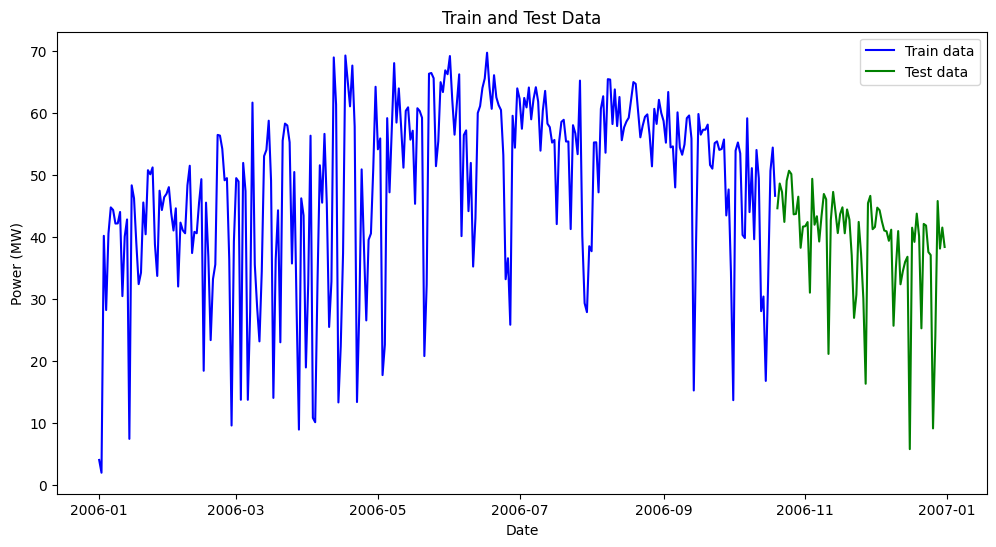

In [116]:
# Plot train and test data
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Train data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test data', color='green')
plt.xlabel('Date')
plt.ylabel('Power (MW)')
plt.title('Train and Test Data')
plt.legend()
plt.show()

In [117]:
# Fit Prophet model
model = Prophet()
model.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/f2p2b8i7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/a53dg_r3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1091', 'data', 'file=/tmp/tmph7_9_8r2/f2p2b8i7.json', 'init=/tmp/tmph7_9_8r2/a53dg_r3.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modeliqgervvf/prophet_model-20240218192712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [118]:
test_data_future_dates = model.make_future_dataframe(periods=len(test_data))
test_data_forecast = model.predict(test_data_future_dates)

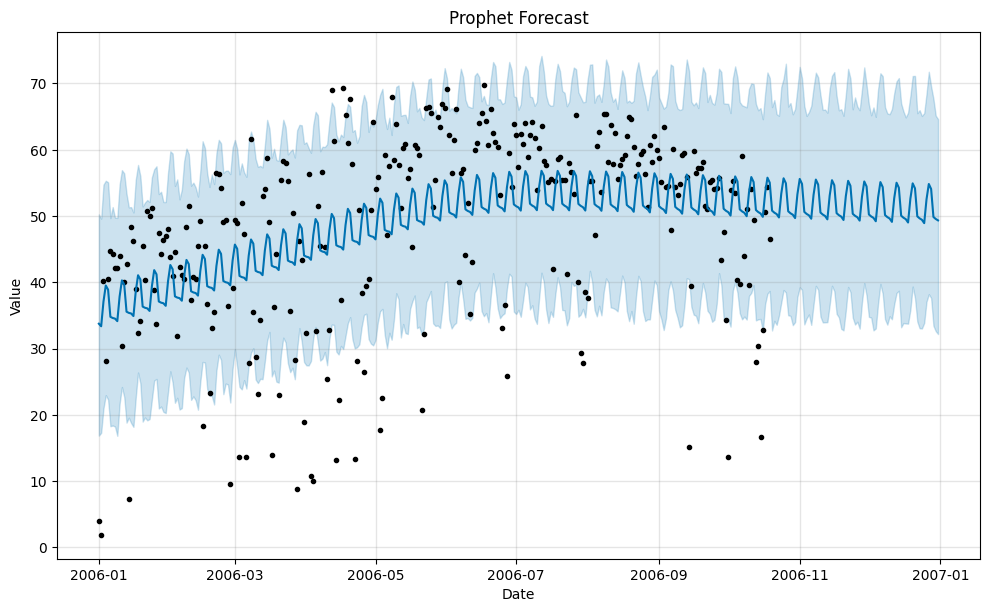

In [119]:
fig = model.plot(test_data_forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

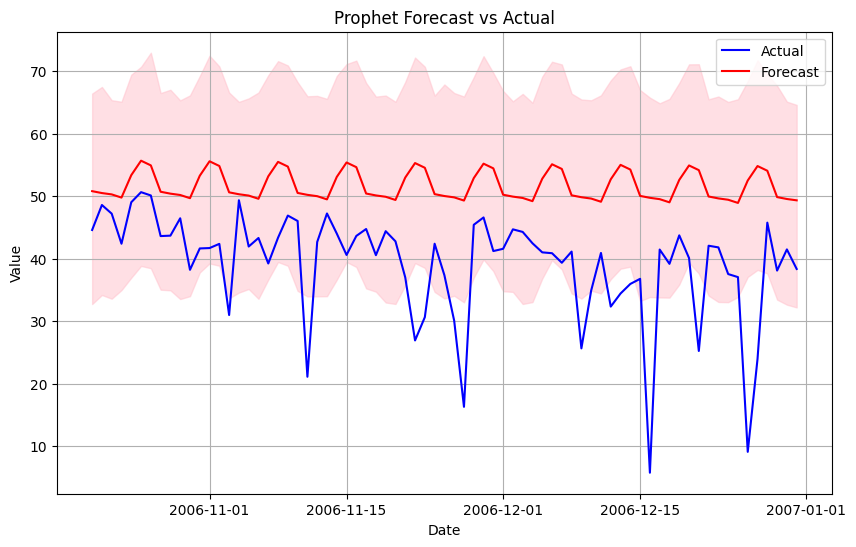

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], test_data_forecast[-len(test_data):]['yhat'], label='Forecast', color='red')
plt.fill_between(test_data['ds'], test_data_forecast[-len(test_data):]['yhat_lower'], test_data_forecast[-len(test_data):]['yhat_upper'], color='pink', alpha=0.5)
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Cross Validation using Prophet

In [123]:
print(len(train_data))
print(len(test_data))
print(len(grouped_data))

292
73
365


In [189]:
data_cv = cross_validation(model, cutoffs = cutoffs, horizon='30 days')

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/dx6to91p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/5gtx33nr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63372', 'data', 'file=/tmp/tmph7_9_8r2/dx6to91p.json', 'init=/tmp/tmph7_9_8r2/5gtx33nr.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelxee6o_xk/prophet_model-20240218195840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:58:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [190]:
data_p = performance_metrics(data_cv)
data_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,19.964777,4.468196,3.775827,0.064375,0.091236,0.061613,1.000000
1,4 days,11.055472,3.324977,2.577561,0.043984,0.034062,0.042475,1.000000
2,5 days,23.668727,4.865052,3.504319,0.066765,0.034062,0.062652,1.000000
3,6 days,27.985619,5.290144,4.578655,0.084450,0.059709,0.080941,1.000000
4,7 days,30.166765,5.492428,5.004768,0.091413,0.059709,0.087606,1.000000
5,8 days,9.218829,3.036252,2.965636,0.049375,0.054953,0.049314,1.000000
6,9 days,15.117788,3.888160,3.608863,0.060329,0.054953,0.058290,1.000000
7,10 days,12.371946,3.517378,3.013270,0.050031,0.033464,0.048387,1.000000
8,11 days,15.904959,3.988102,3.608059,0.062209,0.069998,0.059960,1.000000
9,12 days,8.762718,2.960189,2.778798,0.047465,0.048338,0.046980,1.000000


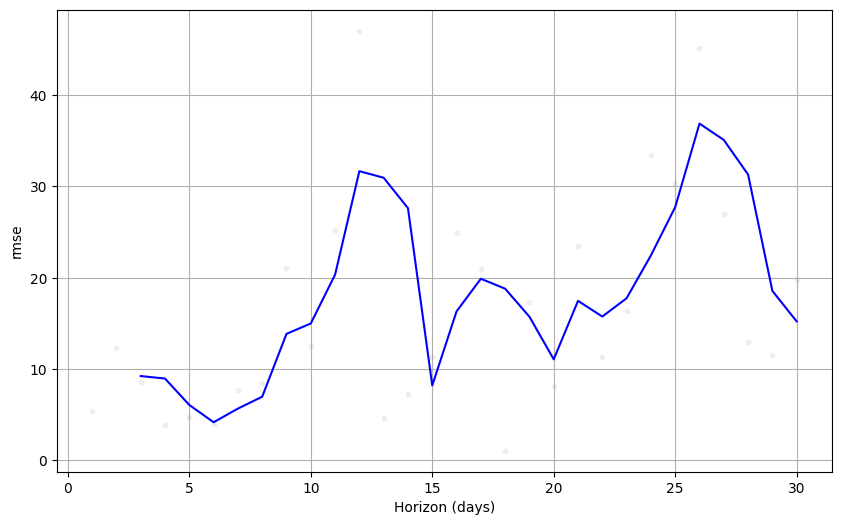

In [144]:
fig = plot_cross_validation_metric(data_cv, metric='rmse')

In [186]:
# Define cutoff dates for cross-validation to match 70/30 train-test split
train_end_date = pd.Timestamp(train_data['ds'].iloc[int(len(train_data) * 0.8)])
cutoffs = [train_end_date]

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmse = []  # Store the RMSEs for each parameter set here

# Use cross-validation to evaluate all parameters
for params in all_params:
    # Initialize Prophet model with given parameters
    m = Prophet(**params)

    # Fit model on training data
    m.fit(train_data)

    # Perform cross-validation
    df_cv = cross_validation(m, cutoffs = cutoffs, horizon='30 days')

    # Calculate performance metrics
    df_p = performance_metrics(df_cv, rolling_window=1)

    # Store RMSE for this parameter set
    rmse.append(df_p['rmse'].values[0])

# Create DataFrame to store tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmse

# Print tuning results
print(tuning_results)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/hvb4l2hg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/7bi_tj24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7432', 'data', 'file=/tmp/tmph7_9_8r2/hvb4l2hg.json', 'init=/tmp/tmph7_9_8r2/7bi_tj24.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_model9__17c4v/prophet_model-20240218195728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:57:28 - cmdstanpy - ERROR - Chain [1] 

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/be81pquf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/418er426.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46044', 'data', 'file=/tmp/tmph7_9_8r2/be81pquf.json', 'init=/tmp/tmph7_9_8r2/418er426.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelpfta7ik1/prophet_model-20240218195729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:57:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/9f8jbt6i.json
DE

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/36l5y1ef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/0cgcquwu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58122', 'data', 'file=/tmp/tmph7_9_8r2/36l5y1ef.json', 'init=/tmp/tmph7_9_8r2/0cgcquwu.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelk4ty4x4q/prophet_model-20240218195732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:57:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/kwvrwajs.json
DE

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/e1kx8kx_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/974vjb1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63962', 'data', 'file=/tmp/tmph7_9_8r2/e1kx8kx_.json', 'init=/tmp/tmph7_9_8r2/974vjb1j.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modeljjqj0m2n/prophet_model-20240218195734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:57:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/9jrp41w5.json
DE

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/8tzhkgax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/6w7sypva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52308', 'data', 'file=/tmp/tmph7_9_8r2/8tzhkgax.json', 'init=/tmp/tmph7_9_8r2/6w7sypva.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelk12ijbjd/prophet_model-20240218195737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:57:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/357myzgr.json
DE

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/feeubp_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/f0qf1f73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79680', 'data', 'file=/tmp/tmph7_9_8r2/feeubp_a.json', 'init=/tmp/tmph7_9_8r2/f0qf1f73.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelnitntwrw/prophet_model-20240218195738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/vqsgozg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/igmulhoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84325', 'data', 'file=/tmp/tmph7_9_8r2/vqsgozg0.json', 'init=/tmp/tmph7_9_8r2/igmulhoq.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelufz0wp3r/prophet_model-20240218195739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/vwx__wjw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/mut6o0ps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84205', 'data', 'file=/tmp/tmph7_9_8r2/vwx__wjw.json', 'init=/tmp/tmph7_9_8r2/mut6o0ps.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelhfdios09/prophet_model-20240218195740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/1mll4b2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/oy4bfli0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7284', 'data', 'file=/tmp/tmph7_9_8r2/1mll4b2e.json', 'init=/tmp/tmph7_9_8r2/oy4bfli0.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelfcv8blto/prophet_model-20240218195740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/6avqwxrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/zrf1oklw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48898', 'data', 'file=/tmp/tmph7_9_8r2/6avqwxrd.json', 'init=/tmp/tmph7_9_8r2/zrf1oklw.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_model6jnsb3uc/prophet_model-20240218195741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/adyckga2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/4g2fzx3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70350', 'data', 'file=/tmp/tmph7_9_8r2/adyckga2.json', 'init=/tmp/tmph7_9_8r2/4g2fzx3w.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelzo2ick6l/prophet_model-20240218195741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/w1npri0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/72olzhcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19765', 'data', 'file=/tmp/tmph7_9_8r2/w1npri0y.json', 'init=/tmp/tmph7_9_8r2/72olzhcx.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_model3nrzueex/prophet_model-20240218195742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/f7dop5ci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/u1k8h0pr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37765', 'data', 'file=/tmp/tmph7_9_8r2/f7dop5ci.json', 'init=/tmp/tmph7_9_8r2/u1k8h0pr.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modeleur4paef/prophet_model-20240218195742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/ld0jg8yz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/fyurfm4t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14958', 'data', 'file=/tmp/tmph7_9_8r2/ld0jg8yz.json', 'init=/tmp/tmph7_9_8r2/fyurfm4t.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_model54tqxi71/prophet_model-20240218195743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/a94cujhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/s2bzsh_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2621', 'data', 'file=/tmp/tmph7_9_8r2/a94cujhu.json', 'init=/tmp/tmph7_9_8r2/s2bzsh_r.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelg8scj0ih/prophet_model-20240218195743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/qou18qa9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/yvwu2zcn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19601', 'data', 'file=/tmp/tmph7_9_8r2/qou18qa9.json', 'init=/tmp/tmph7_9_8r2/yvwu2zcn.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_model1dxxlqvh/prophet_model-20240218195744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/9vu5h1ni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7_9_8r2/q1k0kcbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1170', 'data', 'file=/tmp/tmph7_9_8r2/9vu5h1ni.json', 'init=/tmp/tmph7_9_8r2/q1k0kcbi.json', 'output', 'file=/tmp/tmph7_9_8r2/prophet_modelcsm22ll_/prophet_model-20240218195744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  11.322101
1                     0.001                     0.10  12.237323
2                     0.001                     1.00  12.070609
3                     0.001                    10.00  12.101012
4                     0.010                     0.01  12.292994
5                     0.010                     0.10  14.000719
6                     0.010                     1.00  13.744882
7                     0.010                    10.00  13.590661
8                     0.100                     0.01  11.602593
9                     0.100                     0.10  12.237841
10                    0.100                     1.00  12.266472
11                    0.100                    10.00  12.110999
12                    0.500                     0.01   9.033876
13                    0.500                     0.10   9.840714
14                    0.500             

```
   changepoint_prior_scale  seasonality_prior_scale       rmse
12                    0.500                     0.01   9.033876
13                    0.500                     0.10   9.840714
14                    0.500                     1.00   9.893152
15                    0.500                    10.00   9.924577
0                     0.001                     0.01  11.322101
8                     0.100                     0.01  11.602593
1                     0.001                     0.10  12.237323
9                     0.100                     0.10  12.237841
10                    0.100                     1.00  12.266472
3                     0.001                    10.00  12.101012
11                    0.100                    10.00  12.110999
2                     0.001                     1.00  12.070609
4                     0.010                     0.01  12.292994
6                     0.010                     1.00  13.744882
7                     0.010                    10.00  13.590661
5                     0.010                     0.10  14.000719
```

```
   changepoint_prior_scale  seasonality_prior_scale         mse
12                    0.500                     0.01   81.610911
13                    0.500                     0.10   96.839653
14                    0.500                     1.00   97.874454
15                    0.500                    10.00   98.497220
8                     0.100                     0.01  134.620174
0                     0.001                     0.01  128.189970
9                     0.100                     0.10  149.764756
1                     0.001                     0.10  149.752063
10                    0.100                     1.00  150.466329
11                    0.100                    10.00  146.676301
2                     0.001                     1.00  145.699599
3                     0.001                    10.00  146.434490
4                     0.010                     0.01  151.117700
6                     0.010                     1.00  188.921774
7                     0.010                    10.00  184.706059
5                     0.010                     0.10  196.020120
```

```
   changepoint_prior_scale  seasonality_prior_scale       mae
12                    0.500                     0.01  4.544670
13                    0.500                     0.10  5.111412
14                    0.500                     1.00  5.163625
15                    0.500                    10.00  5.175914
8                     0.100                     0.01  7.270718
0                     0.001                     0.01  6.919189
9                     0.100                     0.10  7.610511
1                     0.001                     0.10  7.608559
10                    0.100                     1.00  7.629908
11                    0.100                    10.00  7.437549
2                     0.001                     1.00  7.380739
3                     0.001                    10.00  7.419465
4                     0.010                     0.01  8.183596
6                     0.010                     1.00  9.552648
7                     0.010                    10.00  9.365782
5                     0.010                     0.10  9.863862
```

```
   changepoint_prior_scale  seasonality_prior_scale      mape
12                    0.500                     0.01  0.153456
13                    0.500                     0.10  0.168881
14                    0.500                     1.00  0.170160
15                    0.500                    10.00  0.170706
8                     0.100                     0.01  0.215953
0                     0.001                     0.01  0.208633
9                     0.100                     0.10  0.226357
1                     0.001                     0.10  0.226325
10                    0.100                     1.00  0.226855
11                    0.100                    10.00  0.222873
2                     0.001                     1.00  0.221733
3                     0.001                    10.00  0.222532
4                     0.010                     0.01  0.234457
6                     0.010                     1.00  0.265609
7                     0.010                    10.00  0.261819
5                     0.010                     0.10  0.271790
```

In [ ]:
best_params = all_params[np.argmin(rmse)]
print(best_params)

In [ ]:
m = Prophet(**best_params)
m.fit(grouped_data)
future = m.make_future_dataframe(periods=31, freq='D')
fcst = m.predict(future)
fig = m.plot(fcst)

In [ ]:
january_month_future_dates = pd.date_range(start='2007-01-01', end='2007-12-31', freq='D')
january_month_future = pd.DataFrame({'ds': january_month_future_dates})

forecast_january = model.predict(january_month_future)

plt.figure(figsize=(10, 6))
plt.plot(forecast_january['ds'], forecast_january['yhat'], label='Forecast', color='red')
plt.fill_between(forecast_january['ds'], forecast_january['yhat_lower'], forecast_january['yhat_upper'], color='pink', alpha=0.5)
plt.title('Prophet Daily Forecast for 2007')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
start_date = '2007-01-01'
end_date = '2007-01-07'
january_week_future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
january_week_future = pd.DataFrame({'ds': january_week_future_dates})

january_week_forecast = model.predict(january_week_future)

plt.figure(figsize=(10, 6))
plt.plot(january_week_forecast['ds'], january_week_forecast['yhat'], label='Forecast', color='red')
plt.fill_between(january_week_forecast['ds'], january_week_forecast['yhat_lower'], january_week_forecast['yhat_upper'], color='pink', alpha=0.5)
plt.title('Prophet Forecast for the First Week of January 2007')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()